© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/phd_students/seleznova/index.html) 2022

https://github.com/mselezniova/MSML22

Distributed under the [Creative Commons Attribution License](https://creativecommons.org/licenses/by/4.0/)

In [2]:
import os

import numpy as np
import pandas as pd

%pylab inline
%config InlineBackend.figure_format='svg'

Populating the interactive namespace from numpy and matplotlib


# Multi-class classification

Until now, we only worked with binary classification, i.e. we had $|\mathcal{Y}|=2$. However, we saw that most common dataset contain more than just two classes. Thus, the goal of this session is to generalize our classification model to the case when $|\mathcal{Y}|>2$.

## One-vs.-rest strategy

One-vs.-rest strategy involves training multiple binary classifiers, each of which considers elements of only one class as positive and elements of all the other classes as negative. Assume we have $K\in\mathbb{N}$ classes and $\mathcal{Y}=\{1,\dots,K\}$. Then we need to train $K$ models $\{h_k\}_{k=1,\dots K}$ and aggregate their outputs to get the final answer. 

### Linear (least squares) classification
In case of linear classification with least squares, one can train $K$ **regression** models with output functions $\{h_k\}_{k=1,\dots K}$. Then the output of the multi-class classifier is obtained by:
$$h(x) = \underset{k\in\{1,\dots K\}}{\operatorname{argmax}} h_k(x)$$

Assume we have a dataset $X\in\mathbb{R}^{N\times d}$, $Y\in\{1,\dots K\}^N$. We can reformulate one-vs.-rest multi-class classification problem as follows:

$$h(X) = [h_1(X),\dots h_K(X)] = [Xw_1 + b_1\mathbb{1}_N, \dots Xw_K + b_k\mathbb{1}_N]= XW + B \in \mathbb{R}^{N\times K},$$

where $W=[w_1,\dots,w_2]\in\mathbb{R}^{d\times K}$ is now a matrix of coefficients and $B=[b_1\mathbb{1}_N,\dots,b_k\mathbb{1}_N]\in\mathbb{R}^{N\times K}$ is a matrix of biases.

To train the classifier, we need to transform the $Y$ vector so that in containes labels corresponding to each classifier: 
$$\tilde{y} = 2*\mathbb{e}_{y} - 1 = [-1,\dots 1, \dots -1] \in \mathbb{R}^{1\times K},$$
where $\mathbb{e}_{i}$ is the $i$-th bias vector. Therefore, $\tilde{y}$ containes values $1$ in the position corresponding to the true class and $-1$ everywhere else, so we have:
$$ y = \underset{k\in\{1,\dots K\}}{\operatorname{argmax}}\tilde{y} $$
Performing this transformation on all the samples, we get $\tilde{Y}\in\mathbb{R}^{N\times K}$. Then, our classifier can be trained by minimizing the following loss:
$$\min_{W,B} \| XW + B - \tilde{Y} \|^2_2 = \min_{W,B} \sum_{k=1}^K \| Xw_k + b_k\mathbb{1}_N - \tilde{Y}[:,k] \|^2_2$$

One can see that we minimize parameters of different classifiers independently. Thus, the solution of this problem is indeed equivalent to optimizing $K$ classifiers.

## One-vs.-one strategy

Another strategy for multi-class classification is to train a separate classifier on every pair of classes. In this case, we would require to train $K(K-1)/2$ classifiers for a single problem and predict labels of new samples using the vote of all the classifiers. This strategy is less common and usually computationally more challenging, so we will not consider it in this class. However, one-vs.-one strategy may be a good choice in some situations, e.g., when it is computationally easier to train many classifiers on smaller datasets instead of one classifier on the whole dataset (e.g. kernel methods).

## Multioutput regression/classification

Multioutput regression/classification works with multidimensional labels, i.e. $\mathcal{Y}\subset\mathbb{R}^K$ with $K>1$. Then the model is trained to minimize the chosen distance between the predictions and the true labels in the multidimensional space. We saw that one-vs.-rest linear regression can be easily reformulated as a multioutput classification.

## Multi-class classification of the Iris dataset

First we load and examine the dataset:

In [417]:
file_name = 'iris_data_set.csv'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
column_names = ['sepal length [cm]', 'sepal width [cm]',
                'petal length [cm]', 'petal width [cm]', 'iris type']

if os.path.exists(file_name):
    print(f'Loading data from local file `{file_name}`...')
    df = pd.read_csv(file_name, index_col=0)
else:
    print(f'Loading data from `{url}`...')
    df = pd.read_csv(url, names=column_names)
    df.to_csv(file_name)
    print('Done.')

Loading data from local file `iris_data_set.csv`...


In [418]:
df

,sepal length [cm],sepal width [cm],petal length [cm],petal width [cm],iris type
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


Split train and test data and extract a two-dimensional projection (for now):

In [419]:
def  train_test_split(df, training_data_fraction, shuffle=True):

    if shuffle is True:
        df_ = df.sample(frac=1).reset_index(drop=True)
    else:
        df_= df
    
    train_df = df_.iloc[:round(training_data_fraction*len(df_)),:]
    test_df = df_.iloc[round(training_data_fraction*len(df_)):,:]
    
    return df_, train_df, test_df

In [507]:
training_data_fraction = .8

df, train_df, test_df =  train_test_split(df, training_data_fraction)

X = df[['sepal length [cm]', 'petal width [cm]']].to_numpy()
Y = df['iris type'].to_numpy()

train_X = train_df[['sepal length [cm]', 'petal width [cm]']].to_numpy()
train_Y = train_df['iris type'].to_numpy()

test_X = test_df[['sepal length [cm]', 'petal width [cm]']].to_numpy()
test_Y = test_df['iris type'].to_numpy()

print('Training data split as follows:')
print(f'  Training data samples: {len(train_df)}')
print(f'      Test data samples: {len(test_df)}')

Training data split as follows:
  Training data samples: 120
      Test data samples: 30


Note that this time we use the raw strings as the class labels instead of redefining the class labels. We will implement our classifier in such a way that it can accept different labels.

In [508]:
Y[:10]

array(['Iris-virginica', 'Iris-virginica', 'Iris-virginica',
       'Iris-versicolor', 'Iris-virginica', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-virginica', 'Iris-versicolor',
       'Iris-virginica'], dtype=object)

Plot the data:

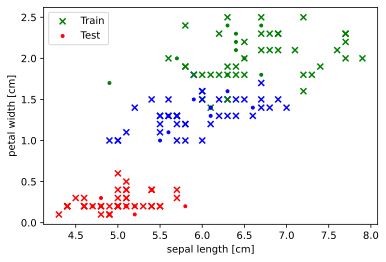

In [509]:
fig, ax = plt.subplots()


colors = train_df['iris type'].replace(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], ['red','blue','green'])
plt.scatter(train_X[:, 0], train_X[:, 1], marker='x', color=colors, label='Train')

colors = test_df['iris type'].replace(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], ['red','blue','green'])
plt.scatter(test_X[:, 0], test_X[:, 1], marker='.', color=colors, label='Test')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend()

Now we define a class for the new classification method. The behavior of this class is similar to the binary classification class. The main changes are as follows:

- As before, we need to account for different possible shapes of the data in this implementation. The comments in the code explain how the code works with shapes.
- We transform the dataset and the labels in the train() method to 1) add a vector of ones to X to account for bias, 2) encode Y as discussed above.
- For efficiency, we transform the data only once and introduce private methods (starting with __ ), which work with the transformed data. These methods should not be called outside of the class. 

In [510]:
class LinearMulticlassClassification:

    def __init__(self, w, b):
        
        self._params = np.vstack((np.array(w, dtype=np.float),  # stack the parameters into a single matrix [W,B]                                
                                  np.array(b, dtype=np.float))) # of shape (d+1,K)
        
        self._w = self._params[:-1,:] # save views of the parameters array as _w and _b
        self._b = self._params[-1,:]  # it's not a copy! when _params changes, _w and _b change
                                      # and vise versa
         
        self.labels = None            # class labels (can be different from [0,1,2])
                                      # labels are saved when the classifier sees Y during training
        
        self.history = [{'w': self._w.copy(),
                         'b': self._b.copy(),
                         'loss': None,
                         'accuracy': None}]
        
        
        
    def h(self, X):
        # the code accounts for any shape of X of the form (n1,n2,...np,d)
        # where d - the number of features
        
        ones_vec = np.ones(X.shape[:-1]+(1,)) # array of ones with shape (n1,n2,...np,1),
        
        _X = np.concatenate((X,ones_vec), axis=-1) # adds new dimension with value one to each point in X
                                                   # (x1,x2,...xd) is transformed to (x1,x2,...xd,1)
                                                   # the shape of X changes from (n1,n2,...np,d) 
                                                   # to (n1,n2,...np,d+1)  
        
        return np.argmax(_X@self._params, axis=-1)
    
    def accuracy(self, X, Y):
        return 1. - np.mean(self.labels[self.h(X)] != Y)
    
    def __accuracy(self, X, Y):
        return 1. - np.mean(np.argmax(X@self._params, axis=-1) != np.argmax(Y, axis=-1))
    
    def __loss(self, X, Y):
        lin_term = X@self._params - Y
        return 0.5/X.shape[0]*np.linalg.norm(lin_term)
    
    def __loss_grad(self, X,Y):
        
        lin_term = X@self._params - Y
        grad = X.T@lin_term/X.shape[0]
        return grad[:-1,:], grad[-1,:]
    
    def labels_encoding(self, Y):
        self.labels = np.unique(Y)
        K = self.labels.size
        y_t = -np.ones(Y.shape+(K,))
    
        for k in range(K):
            ind = np.argwhere(Y==self.labels[k]).T.tolist()
            ind.append([k]*len(ind[0]))
            y_t[tuple(ind)] = 1

        return y_t

    def train(self, X, Y, lr = 1e-3, num_iter = 100):
        
        ones_vec = np.ones(X.shape[:-1]+(1,))
        _X = np.concatenate((X,ones_vec), axis=-1) # same shape transformation as in h()
        _X = _X.reshape((-1,_X.shape[-1]))         # make X two dimensional
                                                   # of shape (n1*n2*...*np,d+1)
        _Y = self.labels_encoding(Y) 
            
        self.history[0]['loss'] = self.__loss(_X,_Y)
        self.history[0]['accuracy'] = self.__accuracy(_X,_Y)
        
        for e in range(num_iter):
            
            grad_w, grad_b = self.__loss_grad(_X,_Y)
            self._w -= lr*grad_w
            self._b -= lr*grad_b
            
            self.history.append({'w': self._w.copy(),
                                 'b': self._b.copy(),
                                 'loss': self.__loss(_X,_Y),
                                 'accuracy': self.__accuracy(_X,_Y)})
            
        return self._w, self._b
    

In [511]:
w = np.zeros((X.shape[1],np.unique(Y).size))
b = [1]*np.unique(Y).size

model = LinearMulticlassClassification(w,b)
model.train(train_X, train_Y, lr = 1e-2, num_iter = 10000)

(array([[ 0.0206592 , -0.20899706, -0.10823976],
        [-1.12700807,  0.33881667,  1.04612862]]),
 array([ 0.89041391,  0.50350194, -0.95057016]))

We see that our classifier momorized the class labels and returns predictions in the form of index in the list of these labels:

In [512]:
model.labels

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [513]:
model.h(X[:10])

array([2, 2, 2, 0, 2, 1, 0, 2, 2, 2])

Now we plot the results and evaluate performance of the classifier:

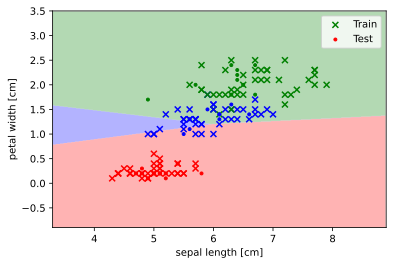

In [514]:
fig, ax = plt.subplots()

x1_min = train_X[:, 0].min() - 1
x1_max = train_X[:, 0].max() + 1
x2_min = train_X[:, 1].min() - 1
x2_max = train_X[:, 1].max() + 1

x1_list, x2_list = np.meshgrid(np.arange(x1_min, x1_max, .01), 
                               np.arange(x2_min, x2_max, .01))

X_list = np.dstack([x1_list, x2_list])
h_list = model.h(X_list)

cmap = matplotlib.colors.ListedColormap(['red', 'blue', 'green'])
plt.contourf(x1_list, x2_list, h_list, cmap=cmap, alpha=.3)

colors = train_df['iris type'].replace(model.labels,['red','blue','green'])
plt.scatter(train_X[:, 0], train_X[:, 1], marker='x',color=colors, label='Train')

colors = test_df['iris type'].replace(model.labels,['red','blue','green'])
plt.scatter(test_X[:, 0], test_X[:, 1], marker='.',color=colors, label='Test')


plt.xlabel('sepal length [cm]')
plt.ylabel('petal width [cm]')
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.legend()

The final train accuracy: 70.0%
Test accuracy: 70.0%


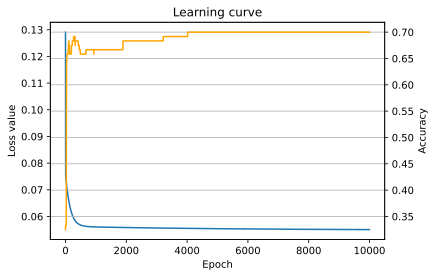

In [515]:
fig, ax = plt.subplots()

loss_history = [h['loss'] for h in model.history]
acc_history = [h['accuracy'] for h in model.history]

ax.plot(range(len(model.history)), loss_history)
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(model.history)), acc_history, color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()

print(f'The final train accuracy: {round(100*acc_history[-1],1)}%')
print(f'Test accuracy: {round(100*model.accuracy(test_X, test_Y),1)}%')

## Training with all the features

We also try to use all the features in the dataset istead of the two-dimensional projection.

In [516]:
training_data_fraction = .8

df, train_df, test_df =  train_test_split(df, training_data_fraction)

X = df.iloc[:,:4].to_numpy()
Y = df['iris type'].to_numpy()

train_X = train_df.iloc[:,:4].to_numpy()
train_Y = train_df['iris type'].to_numpy()

test_X = test_df.iloc[:,:4].to_numpy()
test_Y = test_df['iris type'].to_numpy()

print('Training data split as follows:')
print(f'  Training data samples: {len(train_df)}')
print(f'      Test data samples: {len(test_df)}')

Training data split as follows:
  Training data samples: 120
      Test data samples: 30


In [517]:
w = np.zeros((X.shape[1],np.unique(Y).size))
b = [0]*np.unique(Y).size

model = LinearMulticlassClassification(w,b)
model.train(train_X, train_Y, lr = 1e-2, num_iter = 10000)

(array([[ 0.06583564,  0.20067245, -0.34053088],
        [ 0.44285833, -0.85184321,  0.37424273],
        [-0.41272249,  0.28966931,  0.13586505],
        [-0.13830014, -0.8596503 ,  1.02150244]]),
 array([-0.33419424,  0.98459826, -1.18498821]))

The final train accuracy: 84.2%
Test accuracy: 80.0%


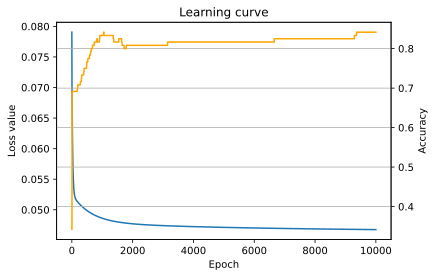

In [518]:
fig, ax = plt.subplots()

loss_history = [h['loss'] for h in model.history]
acc_history = [h['accuracy'] for h in model.history]

ax.plot(range(len(model.history)), loss_history)
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(model.history)), acc_history, color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()

print(f'The final train accuracy: {round(100*acc_history[-1],1)}%')
print(f'Test accuracy: {round(100*model.accuracy(test_X, test_Y),1)}%')

# Exercise

Implement **one-vs.-rest logistic regression** model with GD training. The output function of this model is given by:

$$h(x) = \alpha(XW + B),$$

where $\alpha(t) = \dfrac{1}{1+e^{-t}}$ is applied component-wise (i.e. to every classifier separately). The loss function, same as in case of linear regression, is given by the sum of losses of all the classifiers and can be written as follows:

$$\min_{W, B} \dfrac{1}{NK} \sum_{i=1}^N\sum_{k=1}^K - y_{i}[k]\log(\alpha(\langle x_i, w_k \rangle + b_k)) - 
(1-y_i[k])\log(1-\alpha(\langle x_i, w_k \rangle + b_k))$$
$$= \min_{W, B} - \dfrac{1}{NK} \| Y \odot \log (h(X)) + (1-Y) \odot \log (1-h(X)) \|_1$$